In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Alcohol_Sales.csv",index_col=0,parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

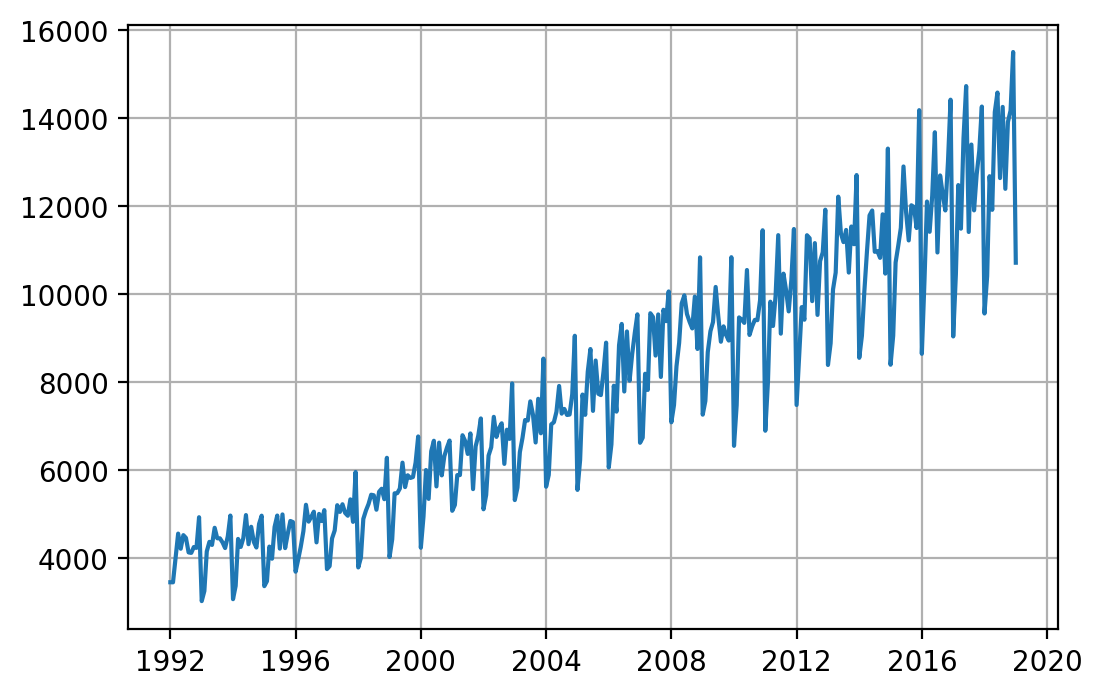

In [5]:
plt.figure(dpi=200)
plt.plot(df.S4248SM144NCEN)
plt.grid()

### 3. Featrue Extraction

In [6]:
y = df.S4248SM144NCEN.values.astype('float')
y.shape

(325,)

In [7]:
test_size = 10
tran_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
len(tran_set),len(test_set)

(315, 10)

## 4. Preprocessing


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
sc = MinMaxScaler(feature_range=(-1,1))

In [11]:
train_mm = sc.fit_transform(tran_set.reshape(-1,1))

In [12]:
train_mm.max(),train_mm.mean(),train_mm.min()

(1.0, -0.20000108542719033, -1.0)

In [13]:
train_mm = torch.FloatTensor(train_mm).reshape(-1)

In [14]:
train_mm.shape

torch.Size([315])

# 5. Data batcher

In [15]:
window_size = 10

def input_data(seq, window_size, label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size):  #if not, we will go out of bound
        window = seq[i:i+window_size]
        label  = seq[i+window_size:i+window_size+label_size]
        out.append((window, label))
    return out

#question: if my window is 10, label size is 1, my seq is ???
#        :  then what is the shape of out??? 

In [16]:
train_data = input_data(train_mm, window_size)
len(train_data)

305

In [17]:
class chakyLSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size = 1
    def __init__(self, input_size = 1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm   = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
        #optional
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))
        
    def forward(self, seq):
        #seq shape: (10)
        seq = seq.reshape(len(seq), 1, -1)
        #seq shape: (10, 1, 1)
        out, (_, _) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape: (L, N, Hout * D) ==> (10, 1, 100)
        out = out[-1, :, :] #(B, Hout)
        #out shape: (1, 100)
        out = self.linear(out)
        #out shape: (1, 1)
        return out
        

## 7. training

In [18]:
torch.manual_seed(999999)
model = chakyLSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 400?, why 40000????

   400
 40000
   400
   400
   100
     1
______
 41301


In [20]:
epochs = 50

for e in range(epochs):
    
    for seq, ytrain in train_data:
        #seq: (10, ); target: (1, )
        # print(seq.shape)
        # print(target.shape)
        yhat = model(seq).reshape(-1)
        loss = criterion(yhat,ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if e %10 == 0 :
        print(f'{e:2.0f} epich : loss = {loss:2.5f}')
print(f'{e} epich : loss = {loss}')

 0 epich : loss = 0.00139
10 epich : loss = 0.00191
20 epich : loss = 0.00494
30 epich : loss = 0.04814
40 epich : loss = 0.00508
49 epich : loss = 0.002957780845463276


## 8. plot losss

### 9. inference

In [23]:
future = window_size
## prepare a lsit of predocit ion and append on this list
preds = train_mm[-window_size:].tolist()

# model.eval() # same as no_grad() all bathnorm and dropout are turn off
for _ in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        yghat = model(seq)
        preds.append(yghat)


In [24]:
test_set

array([11919., 14138., 14583., 12640., 14257., 12396., 13914., 14174.,
       15504., 10718.])

## 10.Denormalize our data

In [27]:
sc

MinMaxScaler(feature_range=(-1, 1))

In [28]:
preds_real = sc.inverse_transform(np.array(preds).reshape(-1,1))

/var/folders/6k/k4c4b7k97xg5ynmwn30pdxtr0000gn/T/ipykernel_9738/1483272989.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_real = sc.inverse_transform(np.array(preds).reshape(-1,1))


In [29]:
preds_real[-10:]

array([[11898.0486455 ],
       [13563.77840498],
       [14964.27822757],
       [11087.90942743],
       [12714.34445539],
       [12219.02994177],
       [12833.81852758],
       [13265.27260873],
       [14961.46525991],
       [ 9673.73927237]])

In [30]:
test_set

array([11919., 14138., 14583., 12640., 14257., 12396., 13914., 14174.,
       15504., 10718.])